Predict insurance cost based on some features.  
More specifically we're going to try to predict the cost of medical insurance for individuals based on a number of different parameters such as age, sex, bmi, children, smoking_status and residential_region.

In [ ]:
# Import required libraries
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Read de insurance dataset
insurance = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv")
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
insurance.isna().sum() # dataset = dataset.dropna()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

We're going to have to turn the non-numerical columns into numbers (because a neural network can't handle non-numerical inputs),  
To do so, we will use the get_dummies() method in pandas.  
It converts categorical variables (like the sex, smoker and region columns) into numerical variables using one-hot encoding.

In [ ]:
# Turn all categories into numbers
insurance_one_hot = pd.get_dummies(insurance)
insurance_one_hot.head() # view the transformed columns

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1,0,0,1,0,0,0,1
1,18,33.770,1,1725.55230,0,1,1,0,0,0,1,0
2,28,33.000,3,4449.46200,0,1,1,0,0,0,1,0
3,33,22.705,0,21984.47061,0,1,1,0,0,1,0,0
4,32,28.880,0,3866.85520,0,1,1,0,0,1,0,0


In [ ]:
# Now we will split the data into features (X) and labels (y).
# Create X & y values
X = insurance_one_hot.drop("charges", axis=1)
y = insurance_one_hot["charges"]

In [ ]:
# Feature scaling: normalize data (values between 0 and 1)
# One-hot encode
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Create column transformer (this will help us normalize/preprocess our data)
ct = make_column_transformer(
    (MinMaxScaler(), ["age", "bmi", "children"]), # get all values between 0 and 1
    (OneHotEncoder(handle_unknown="ignore"), ["sex", "smoker", "region"])
)

In [ ]:
# Create X & y
X = insurance.drop("charges", axis=1)
y = insurance["charges"]


In [ ]:
# Build our train and test sets (use random state to ensure same split as before)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Fit column transformer on the training data only (doing so on test data would result in data leakage)
ct.fit(X_train)

ColumnTransformer(transformers=[('minmaxscaler', MinMaxScaler(),
                                 ['age', 'bmi', 'children']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['sex', 'smoker', 'region'])])

In [ ]:
# Transform training data and test data with normalization (MinMaxScaler) and one hot encoding (OneHotEncoder)
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

In [ ]:
# Set random seed
tf.random.set_seed(42)

In [ ]:
# Build the model (3 layers, 100, 10, 1 units)
insurance_model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(1)
])

In [ ]:
# Compile the model
insurance_model_3.compile(loss=tf.keras.losses.mae,
                          optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                          metrics=['mae'])

In [ ]:
# Fit the model for 200 epochs
history = insurance_model_3.fit(X_train_normal,
                                y_train,
                                epochs=200,
                                validation_split=0.2) # # Calculate validation results on 20% of the training data.

In [ ]:
#Visualize the model's training progress using the stats stored in the history object:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,val_loss,val_mae,epoch
195,3560.390869,3560.390869,3130.174316,3130.174316,195
196,3560.910645,3560.910645,3124.657715,3124.657715,196
197,3560.986084,3560.986084,3135.970215,3135.970215,197
198,3561.813965,3561.813965,3137.986816,3137.986816,198
199,3560.759277,3560.759277,3129.193848,3129.193848,199


In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  #plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

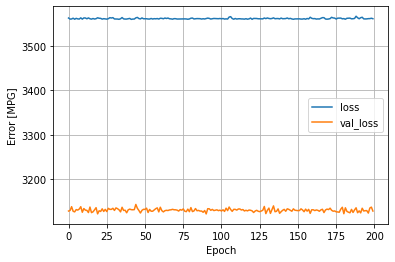

In [ ]:
plot_loss(history)

In [ ]:
# Collect the results on the test set for later:


test_results = {}

test_results['charges'] = insurance_model_3.evaluate(
    X_test_normal,
    y_test, verbose=0)

In [ ]:
# Evaluate the model
insurance_model_3_loss, insurance_model_3_mae = insurance_model_3.evaluate(X_test_normal, y_test)

9/9 [==============================] - 0s 4ms/step - loss: 3158.1470 - mae: 3158.1470


Regression with a deep neural network (DNN)
In the previous section, you implemented a linear model for multiple inputs.

Here, you will implement multiple-input DNN models.

The code is basically the same except the model is expanded to include some "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

Two hidden, non-linear, Dense layers with the ReLU (relu) activation function nonlinearity.  

A linear Dense single-output layer.  

Both models will use the same training procedure, so the compile method is included in the build_and_compile_model function below.

In [ ]:
insurance_model_deep = tf.keras.Sequential([
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1)
  ])

In [ ]:
insurance_model_deep.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))


In [ ]:
# Fit the model for 200 epochs
history_deep = insurance_model_deep.fit(X_train_normal,
                                        y_train,
                                        epochs=1000,
                                        validation_split=0.2) # # Calculate validation results on 20% of the training data.

In [ ]:
insurance_model_deep.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 256)               3072      
                                                                 
 dense_31 (Dense)            (None, 128)               32896     
                                                                 
 dense_32 (Dense)            (None, 64)                8256      
                                                                 
 dense_33 (Dense)            (None, 1)                 65        
                                                                 
Total params: 44,289
Trainable params: 44,289
Non-trainable params: 0
_________________________________________________________________


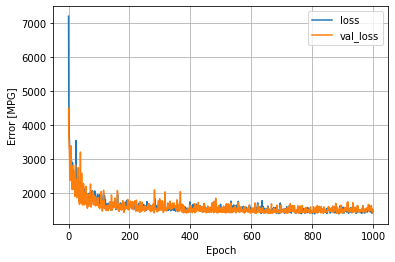

In [ ]:
plot_loss(history_deep)

9/9 [==============================] - 0s 3ms/step


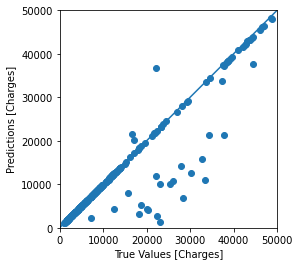

In [ ]:
test_predictions = insurance_model_deep.predict(X_test_normal).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [Charges]')
plt.ylabel('Predictions [Charges]')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [ ]:
# It appears that the model predicts reasonably well.

In [ ]:
# If you're happy with the model, save it for later use with Model.save:

insurance_model_deep.save('insurance_model_deep')